## NOTE
save your notebook in your PC, this is temporary page




In [3]:
# !pip install CoolProp==6.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 2.1 MB/s eta 0:00:0000:0100:01m


<br><br><br>

---

## CoolProp Function의 사용예시
이제 Python Colab을 통해서 CoolProp를 사용하는 예시와 값을 확인해 보겠습니다.
   
먼저 CoolProp 모듈을 불러옵니다. 설치합니다.

<br>

In [2]:
import CoolProp
print(CoolProp.__version__, CoolProp.__gitrevision__)

from CoolProp.CoolProp import PropsSI

# 정상적으로 불러오면, 최신버전인 6.4.x으로 시작하는 글자가 아래에 보입니다
# 6.4.1 3cd0500d029447481b3ad0ad7fe47827d1cf78b7

6.4.3 85b56052816f43b74e49d6f6561a4383471f467f


In [5]:

def GetDensity(pressure_bara, temp_degC):
    result_ = PropsSI('D', 'T', 273.15 + temp_degC , 'P', 1e5 * pressure_bara, 'IF97::Water')
    return result_


def calc_frictionfactor(dia, roughness, reynolds):
    """ get friction factor
        calculate fluid friction factor using Niazkar Method

    Args:
        dia (number): diameter, mm
        roughness (number): absolute roughness of pipe, mm
        reynolds (number): reynolds number, -
    """
    import math
    a = -2 * math.log10(roughness / dia / 3.7 + 4.5547 / math.pow(reynolds, 0.8784))
    b = -2 * math.log10(roughness / dia / 3.7 + (2.51 * a) / reynolds)
    c = -2 * math.log10(roughness / dia / 3.7 + (2.51 * b) / reynolds)
    Freverse = math.pow(a - math.pow(b - a, 2) / (c - 2 * b + a), 2)
    return 1 / Freverse

In [6]:

# fluid condition
pressure_bara = 2.0
temp_degC = 50

# system condition
massflow = ""       # tonm/h
volumeflow = ""     # m3/h
pipe_diameter = 50  # mm
pipe_length = 50    # m
pipe_schedule = ""  # sch STD/XS/XXS, 20/40/80


In [7]:

# calculate pipe friction factor

dia = 50
roughness = 0.046
reynolds = 573000

calc_frictionfactor(dia,roughness, reynolds)

0.01980176657939819

In [8]:

calc_frictionfactor?

Signature: calc_frictionfactor(dia, roughness, reynolds)
Docstring:
get friction factor
    calculate fluid friction factor using Niazkar Method

Args:
    dia (number): diameter, mm
    roughness (number): absolute roughness of pipe, mm
    reynolds (number): reynolds number, -
File:      /tmp/ipykernel_26091/3707349332.py
Type:      function

In [9]:

# Density [kg/m3] of Steam/Water at 10 bar(10 x 1e5 Pa) and 250'C
PropsSI('D', 'T', 273.15 + 250 , 'P', 10e5, 'Water')

# 4.296515473420293

4.296515473420293

In [10]:

density = GetDensity(pressure_bara, temp_degC)
print(f"Water Density: {density} kg/m3")

Water Density: 988.0903894427627 kg/m3


<br><br>

## 사용 예시_Actual Example

### ex020: Steam Density

In [11]:
# Water - IF97 을 사용한 물성치
# Density [kg/m3] of Saturated Water at 9.5 bar(9.5 x 1e5 Pa) and Quality 0
PropsSI('D', 'Q', 0 , 'P', 9.5e5, 'IF97::Water')

# 889.4827583337902

889.4827583337902

FileNotFoundError: [Errno 2] No such file or directory: '/content/pipe-diameter-1.png'

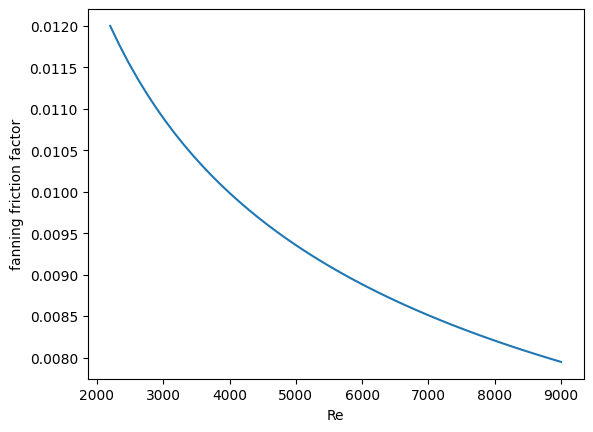

In [12]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

T = 25 + 273.15
Q = 2.5e-3       # m^3/s
deltaP = 103000  # Pa
deltaL = 100     # m

#Note these correlations expect dimensionless T, where the magnitude
# of T is in K

def rho(T):
    return 46.048 + 9.418 * T -0.0329 * T**2 +4.882e-5 * T**3 - 2.895e-8 * T**4

def mu(T):
    return np.exp(-10.547 + 541.69 / (T - 144.53))

def fanning_friction_factor_(Re):
    if Re < 2100:
        raise Exception('Flow is probably not turbulent, so this correlation is not appropriate.')
    # solve the Nikuradse correlation to get the friction factor
    def fz(f): return 1.0/np.sqrt(f) - (4.0*np.log10(Re*np.sqrt(f))-0.4)
    sol, = fsolve(fz, 0.01)
    return sol

fanning_friction_factor = np.vectorize(fanning_friction_factor_)
Re = np.linspace(2200, 9000)
f = fanning_friction_factor(Re)

plt.plot(Re, f)
plt.xlabel('Re')
plt.ylabel('fanning friction factor')
# You can see why we use 0.01 as an initial guess for solving for the
# Fanning friction factor; it falls in the middle of ranges possible
# for these Re numbers.
plt.savefig('/content/pipe-diameter-1.png')

def objective(D):
    v = Q / (np.pi * D**2 / 4)
    Re = D * v * rho(T) / mu(T)

    fF = fanning_friction_factor(Re)

    return deltaP - 2 * fF * rho(T) * deltaL * v**2 / D

D, = fsolve(objective, 0.04)

print('The minimum pipe diameter is {0} m\n'.format(D))